In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm

INPUT_SIZE = 28 * 28
HIDDEN_1_SIZE = 300
HIDDEN_2_SIZE = 100
OUTPUT_SIZE = 10
BATCH_SIZE = 32
EPOCH_NUM = 4

# 标准化、归一化
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5], [0.5, 0.5])]
)

train_set = torchvision.datasets.MNIST(root='./data', download=True, transform=transform)

test_set = torchvision.datasets.MNIST(root='./data', download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, num_workers=2)

In [14]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()

        self.fc1 = nn.Linear(INPUT_SIZE, HIDDEN_1_SIZE)
        self.bn1 = nn.BatchNorm1d(HIDDEN_1_SIZE)
        self.fc2 = nn.Linear(HIDDEN_1_SIZE, HIDDEN_2_SIZE)
        self.bn2 = nn.BatchNorm1d(HIDDEN_2_SIZE)
        self.fc3 = nn.Linear(HIDDEN_2_SIZE, OUTPUT_SIZE)

    def forward(self, x):
        x = x.view(-1, INPUT_SIZE)
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.fc3(x)

        return x

net3 = SimpleNet()
print(net3)

SimpleNet(
  (fc1): Linear(in_features=784, out_features=300, bias=True)
  (bn1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


In [15]:
criterion = nn.CrossEntropyLoss()

# lr 如何设置 momentum
optimizer = optim.SGD(net3.parameters(), lr=0.02, momentum=0.9)

In [16]:
train_loss_hist = []
test_loss_hist = []

for epoch in tqdm(range(EPOCH_NUM)):
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        images, labels = data
        outputs = net3(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        if(i % 250 == 0):
            with torch.no_grad():
                for test_data in testloader:
                    test_images, test_labels = test_data
                    test_outputs = net3(test_images)
                    test_loss = criterion(test_outputs, test_labels)
            
            train_loss_hist.append(running_loss / 250)
            test_loss_hist.append(test_loss.item())
            running_loss = 0.0

        if(i % 1000 == 0):
            print('step: %d loss: %.3f' % (i, loss))

0%|          | 0/4 [00:00<?, ?it/s]step: 0 loss: 2.369
step: 1000 loss: 0.285
 25%|██▌       | 1/4 [01:12<03:38, 72.86s/it]step: 0 loss: 0.147
step: 1000 loss: 0.085
 50%|█████     | 2/4 [02:28<02:27, 73.76s/it]step: 0 loss: 0.143
step: 1000 loss: 0.011
 75%|███████▌  | 3/4 [03:40<01:13, 73.23s/it]step: 0 loss: 0.007
step: 1000 loss: 0.021
100%|██████████| 4/4 [04:58<00:00, 74.66s/it]


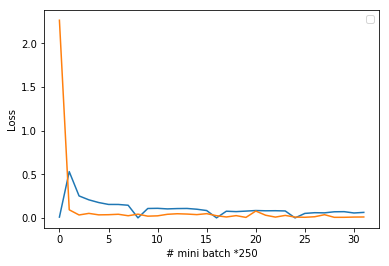

In [18]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_loss_hist)
plt.plot(test_loss_hist)
plt.legend('train_loss', 'test_loss')
plt.xlabel('# mini batch *250')
plt.ylabel('Loss')

In [20]:
# 测试模型

correct = 0.0
total = 0.0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net3(images)
        _, predicted = torch.max(outputs.data, 1)

        correct += (predicted == labels).sum()
        total += labels.size(0)
    
print('准确率：', float(correct) / total)

准确率： 0.9838666666666667


In [ ]:
# 准确率： 0.9838666666666667